In [1]:
%matplotlib nbagg
import numpy
from matplotlib.pyplot import subplots

In [2]:
size = 512
r0 = 51
y,x = numpy.ogrid[-size//2:size-size//2,-size//2:size-size//2]
r2 = x*x+y*y
img = r2<r0*r0
rec = numpy.fft.fftshift(abs(numpy.fft.fft2(img))**2)

<IPython.core.display.Javascript object>


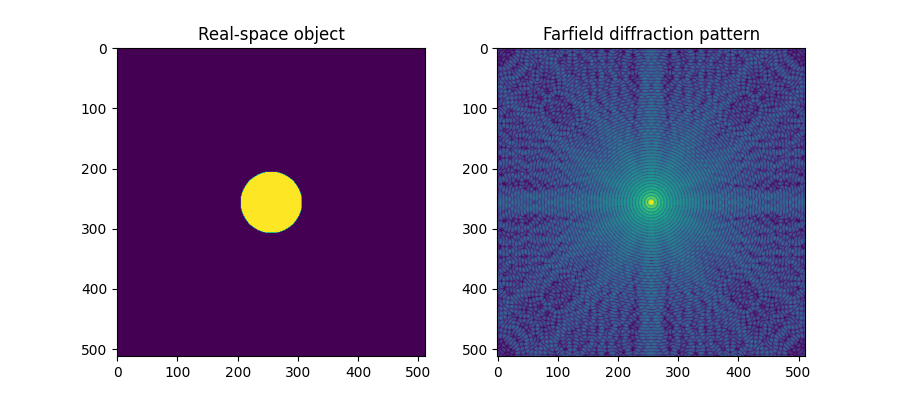

In [3]:
fig, ax = subplots(1, 2, figsize=(9,4))
ax[0].imshow(img)
ax[0].set_title("Real-space object")
ax[1].imshow(numpy.arcsinh(rec))
ax[1].set_title("Farfield diffraction pattern")
pass

In [4]:
print("position of the center:", 
      (rec*numpy.arange(size)).sum()/rec.sum(),
      (rec*(numpy.atleast_2d(numpy.arange(size)).T)).sum()/rec.sum())

position of the center: 255.99381203283914 255.9938120328391


In [5]:
import os
import numpy
from matplotlib.pyplot import subplots
import glob
import fabio
import h5py
import hdf5plugin
import pyopencl as cl
from pyopencl import array as cla
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import sys
import logging
logging.basicConfig(level=logging.INFO)
from math import ceil, floor
import numpy
import pyopencl
from pyopencl import array as cla
import time
import glob
import fabio
import h5py
import hdf5plugin
from silx.opencl.processing import OpenclProcessing, BufferDescription, KernelContainer
from silx.opencl.common import query_kernel_info
# from pynx.cdi.cdi import save_cdi_data_cxi
import codecs
import argparse

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("preprocess_cdi")


EXIT_SUCCESS = 0
EXIT_FAILURE = 1
EXIT_ARGUMENT_FAILURE = 2


def as_str(smth):
    "Ensure to be a string"
    if isinstance(smth, bytes):
        return smth.decode()
    else:
        return str(smth)

In [6]:
nframes = size
shape = size, size
center = (size//2, size//2)
pixel_size = numpy.float32(75e-6)
distance = numpy.float32(33)
dummy = numpy.float32(0.0)
volume_shape=(size,size, size)

In [7]:
ctx = cl.create_some_context(interactive=False)
queue = cl.CommandQueue(ctx)
ctx

<pyopencl.Context at 0x1dd93f0 on <pyopencl.Device 'Intel(R) HD Graphics Haswell Ultrabook GT3 reserved' on 'Intel Gen OCL Driver' at 0x7ff8600095e0>>

In [8]:
class Regrid3D(OpenclProcessing):
    "Project a 2D frame to a 3D volume taking into account the curvature of the Ewald's sphere"
    kernel_files = ["regrid.cl"]

    def __init__(self, mask, volume_shape, center, pixel_size, distance, slab_size=None, scale=None,
                 ctx=None, devicetype="all", platformid=None, deviceid=None,
                 block_size=None, memory=None, profile=False):
        """
        :param mask: numpy array with the mask: needs to be of the same shape as the image
        :param volume_shape: 3-tuple of int
        :param center: 2-tuple of float (y,x)
        :param pixel_size: float, size of the pixel in meter
        :param distance: float, sample detector distance in meter
        :param slab_size: Number of slices to be treated at one, the best is to leave the system guess
        :param scale: zoom factor, 2 is like a 2x2x2 binning of the volume. Allows to work with smaller volumes.
        :param ctx: actual working context, left to None for automatic
                    initialization from device type or platformid/deviceid
        :param devicetype: type of device, can be "CPU", "GPU", "ACC" or "ALL"
        :param platformid: integer with the platform_identifier, as given by clinfo
        :param deviceid: Integer with the device identifier, as given by clinfo
        :param block_size: preferred workgroup size, may vary depending on the
                            out come of the compilation
        :param memory: minimum memory available on device
        :param profile: switch on profiling to be able to profile at the kernel
                         level, store profiling elements (makes code slightly slower)
        """
        OpenclProcessing.__init__(self, ctx=None, devicetype=devicetype, platformid=platformid, deviceid=deviceid,
                                  block_size=block_size, memory=memory, profile=profile)

        self.image_shape = tuple(numpy.int32(i) for i in mask.shape)
        logger.info("image_shape: %s", self.image_shape)
        self.volume_shape = tuple(numpy.int32(i) for i in volume_shape[:3])
        logger.info("volume_shape: %s", self.volume_shape)
        self.center = tuple(numpy.float32(i) for i in center)
        logger.info("center y,x: %s", self.center)
        self.pixel_size = numpy.float32(pixel_size)
        logger.info("pixel_size: %s", self.pixel_size)
        self.distance = numpy.float32(distance)
        logger.info("distance: %s", self.distance)
        self.scale = numpy.float32(1 if scale is None else scale)
        logger.info("scale: %s", self.scale)
        if slab_size:
            self.slab_size = int(slab_size)
        else:
            self.slab_size = self.calc_slabs()

        self.nb_slab = int(ceil(self.volume_shape[1] / self.slab_size))
        # Homogenize the slab size ... no need to stress the GPU memory
        self.slab_size = numpy.int32(ceil(self.volume_shape[1] / self.nb_slab))

        self.slicing = self.calc_slicing()
        logger.info(os.linesep.join(["Slicing pattern:"] + [f"slab Y [{k[0]:4d}:{k[1]:4d}] <=> image lines [{v[0]:4d}:{v[1]:4d}]" for k,v in self.slicing.items()]))

        buffers = [BufferDescription("image", self.image_shape, numpy.float32, None),
                   BufferDescription("mask", self.image_shape, numpy.uint8, None),
                   BufferDescription("signal", (self.volume_shape[0], self.slab_size, self.volume_shape[2]), numpy.float32, None),
                   BufferDescription("norm", (self.volume_shape[0], self.slab_size, self.volume_shape[2]), numpy.int32, None),
                   ]
        self.allocate_buffers(buffers, use_array=True)
        self.compile_kernels(["regrid.cl"])
        self.wg = {"normalize_signal": self.kernels.max_workgroup_size("normalize_signal"),  # largest possible WG
                   "memset_signal": self.kernels.max_workgroup_size("memset_signal"),  # largest possible WG
                   "regid_CDI_slaby": self.kernels.min_workgroup_size("regid_CDI_slaby")}
        self.send_mask(mask)
        self.progress_bar = None

    def calc_slabs(self):
        "Calculate the height of the slab depending on the device's memory. The larger, the better"
        float_size = numpy.dtype(numpy.float32).itemsize
        int_size = numpy.dtype(numpy.int32).itemsize
        device_mem = self.device.memory
        image_nbytes = numpy.prod(self.image_shape) * float_size
        mask_nbytes = numpy.prod(self.image_shape) * 1
        volume_nbytes = self.volume_shape[0] * self.volume_shape[2] * (float_size + int_size)
        tm_slab = (0.8 * device_mem - image_nbytes - mask_nbytes) / volume_nbytes

        device_mem = self.ctx.devices[0].max_mem_alloc_size
        volume_nbytes = self.volume_shape[0] * self.volume_shape[2] * float_size
        am_slab = device_mem / volume_nbytes
        logger.info("calc_slabs: Volume size in y: %d. Limits from total memory: %.1f lines and max allocatable mem limits to %.1f lines", self.volume_shape[1], tm_slab, am_slab)
        return  int(min(self.volume_shape[0], tm_slab, am_slab))

    def calc_slicing(self):
        "Calculate the slicing, i.e, for which slab in output, which lines of the image are needed"
        shape = self.volume_shape[1]  # Number of lines in y
        shape_2 = shape // 2
        size = self.slab_size  # , slicing along y
        dist = self.distance
        center = self.center[0]  # Along y
        d0 = max(self.image_shape[0] - self.center[0], self.center[0])
        d1 = max(self.image_shape[1] - self.center[1], self.center[1])
        scale = numpy.sqrt(dist ** 2 + self.pixel_size * (d0 ** 2 + d1 ** 2)) / dist  # >1
        res = {}
        for slab_start in range(0, shape, size):
            slab = (slab_start, min(shape, slab_start + size))
            lower = min((slab[0] - shape_2) / self.scale + center,
                        (slab[0] - shape_2) * scale / self.scale + center)
            upper = max((slab[1] - shape_2) / self.scale + center,
                        (slab[1] - shape_2) * scale / self.scale + center)
            res[slab] = (max(0, int(floor(lower))),
                         min(self.image_shape[0], int(ceil(upper))))
        return res

    def compile_kernels(self, kernel_files=None, compile_options=None):
        """Call the OpenCL compiler
        :param kernel_files: list of path to the kernel
            (by default use the one declared in the class)
        :param compile_options: string of compile options
        """
        # concatenate all needed source files into a single openCL module
        kernel_files = kernel_files or self.kernel_files
        kernel_src = "\n".join(open(i).read() for i in kernel_files)

        compile_options = compile_options or self.get_compiler_options()
        logger.info("Compiling file %s with options %s", kernel_files, compile_options)
        try:
            self.program = pyopencl.Program(self.ctx, kernel_src).build(options=compile_options)
        except (pyopencl.MemoryError, pyopencl.LogicError) as error:
            raise MemoryError(error)
        else:
            self.kernels = KernelContainer(self.program)

    def send_image(self, image, slice_=None):
        """
        Send image to the GPU
        
        :param image: 2d numpy array
        :param slice: slice_ object with the start and end of the buffer to be copied
        :return: Nothing
        """
        image_d = self.cl_mem["image"]
        if slice_ is not None:
             slice_ = slice(max(0, slice_.start), min(self.image_shape[0], slice_.stop))
             img = numpy.ascontiguousarray(image[slice_], dtype=numpy.float32)
             evt = pyopencl.enqueue_copy(self.queue, image_d.data, img)
             self.profile_add(evt, "Copy image H --> D")
        else:
            assert image.shape == self.image_shape
            image_d.set(numpy.ascontiguousarray(image, dtype=numpy.float32))
            self.profile_add(image_d.events[-1], "Copy image H --> D")

    def send_mask(self, mask):
        """
        Send mask to the GPU
        """
        mask_d = self.cl_mem["mask"]
        assert mask_d.shape == self.image_shape
        mask_d.set(numpy.ascontiguousarray(mask, dtype=numpy.uint8))
        self.profile_add(mask_d.events[-1], "Copy mask H --> D")

    def project_one_frame(self, frame,
                          rot, d_rot,
                          vol_slice, img_slice=None,
                          oversampling_img=1, oversampling_rot=1):
        """Projection of one image onto one slab
        :param frame: numpy.ndarray 2d, floa32 image
        :param rot: angle of rotation
        :param d_rot: angular step (used for oversampling_rot)
        :param vol_slice: Start/end row in the volume (slab along y)
        :param img_slice: Start/end row in the image
        :oversampling_img: Each pixel will be split in n x n and projected that many times
        :oversampling_rot: project multiple times each image between rot and rot+d_rot 
        :return: None
        """

        self.send_image(frame, img_slice)
        if img_slice is None:
            img_slice = slice(0,  self.image_shape[0])
        wg = self.wg["regid_CDI_slaby"]
        ts = int(ceil(self.image_shape[1] / wg)) * wg
        evt = self.program.regid_CDI_slaby(self.queue, (ts, img_slice.stop-img_slice.start) , (wg, 1),
                                           self.cl_mem["image"].data,
                                           self.cl_mem["mask"].data,
                                           *self.image_shape,
                                           img_slice.start, img_slice.stop,
                                           self.pixel_size,
                                           self.distance,
                                           rot, d_rot,
                                           *self.center,
                                           self.scale,
                                           self.cl_mem["signal"].data,
                                           self.cl_mem["norm"].data,
                                           self.volume_shape[-1],
                                           self.slab_size,
                                           vol_slice.start,
                                           vol_slice.stop,
                                           oversampling_img,
                                           oversampling_rot)
        self.profile_add(evt, "Projection onto slab")

    def project_frames(self, l_frames, angles, step,
                       vol_slice, img_slice=None,
                       oversampling_img=1, oversampling_rot=1,
                       ):
        """
        Project all frames onto the slab.
        
        :param l_frames: list of frames
        :param l_angles: angles associated with the frame
        :param step: step size 
        :param vol_slice:  fraction of the volume to use (slicing along Y!)
        :param img_slice:  fraction of the image to use
        :return: the slab 
        """
        if self.progress_bar:
            self.progress_bar.update(message="memset slab")
        self.clean_slab()

        if vol_slice.stop - vol_slice.start > self.slab_size:
            raise RuntimeError("Too many data to fit into memory")
        for angle, frame in zip(angles, l_frames):
            if self.progress_bar:
                self.progress_bar.update(message=f"Project angle {angle:.1f}")
            self.project_one_frame(frame, angle, step,
                                   vol_slice, img_slice,
                                   oversampling_img, oversampling_rot)

        if self.progress_bar:
            self.progress_bar.update(message="get slab")
        return self.get_slab()

    def process_all(self, frames,
                    oversampling_img=1,
                    oversampling_rot=1,
                    ):
        """Project all frames and rebuild the 3D volume
        :param frames: dict with angle: frame as numpy.array
        :param oversample_img
        
        :return: 3D volume as numpy array
        """
        angles = list(frames.keys())
        angles.sort()
        nangles = numpy.array(angles, dtype=numpy.float32)
        steps = nangles[1:] - nangles[:-1]
        step = steps.min()
        l_frames = [frames[a] for a in angles]
        oversampling_img = numpy.int32(oversampling_img)
        oversampling_rot = numpy.int32(oversampling_rot)

        if self.progress_bar:
            self.progress_bar.max_value = (len(frames) + 2) * len(self.slicing)

        full_volume = numpy.empty(self.volume_shape, dtype=numpy.float32)

        for slab_idx, img_idx in self.slicing.items():
            vol_slice = slice(numpy.int32(slab_idx[0]), numpy.int32(slab_idx[1]))
            img_slice = slice(numpy.int32(img_idx[0]), numpy.int32(img_idx[1]))
            if self.progress_bar:
                self.progress_bar.title = "Projection onto slab %04i-%04i" % (vol_slice.start, vol_slice.stop)
            slab = self.project_frames(l_frames, nangles, step,
                                       vol_slice, img_slice,
                                       oversampling_img, oversampling_rot)
            full_volume[:, vol_slice,: ] = slab[:,: vol_slice.stop - vol_slice.start,:]
        return full_volume

    def clean_slab(self):
        "Memset the slab"
        size = self.slab_size * self.volume_shape[1] * self.volume_shape[2]
        wg = self.wg["memset_signal"]
        ts = int(ceil(size / wg)) * wg
        evt = self.program.memset_signal(self.queue, (ts,), (wg,),
                                         self.cl_mem["signal"].data,
                                         self.cl_mem["norm"].data,
                                         numpy.uint64(size))
        self.profile_add(evt, "Memset signal/count")

    def get_slab(self):
        """
        After all frames have been projected onto the slab, retrieve it after normalization 
        
        :return: Ndarray of size (slab_size, volume_size_1, volume_size_2) 
        """
        size = self.slab_size * self.volume_shape[1] * self.volume_shape[2]
        wg = self.wg["normalize_signal"]
        ts = int(ceil(size / wg)) * wg
        signal_d = self.cl_mem["signal"]
        norm_d = self.cl_mem["norm"]
        evt = self.program.normalize_signal(self.queue, (ts,), (wg,),
                                            signal_d.data,
                                            norm_d.data,
                                            numpy.uint64(size))
        self.profile_add(evt, "Normalization signal/count")
        result = signal_d.get()
        if signal_d.events:
            self.profile_add(signal_d.events[-1], "Copy slab D --> H")
        return result

In [9]:
full_volume = numpy.zeros(shape, dtype=numpy.float32)
mask = numpy.zeros(shape, "int8")
regrid = Regrid3D(mask=mask, 
                  volume_shape=volume_shape, 
                  center=center, 
                  pixel_size=pixel_size, 
                  distance=distance, 
                  slab_size=None, 
                  scale=1,
                  profile=1,
                  ctx=ctx)
frames = {i: rec for i in numpy.linspace(-88, 88, 512, endpoint=True)}

/home/kieffer/.venv/py39/lib/python3.9/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


In [10]:
%time res = regrid.process_all(frames, 5, 5)

CPU times: user 21min 54s, sys: 3.26 s, total: 21min 58s
Wall time: 5min 54s


In [11]:
numpy.nanmax(res)

66014516.0

In [12]:
print("\n".join(regrid.log_profile(1)))


OpenCL kernel profiling statistics in milliseconds for: Regrid3D
                                       Kernel name (count):      min   median      max     mean      std
                                 Copy mask H --> D (    1):    0.109    0.109    0.109    0.109    0.000
                               Memset signal/count (    1):  237.844  237.844  237.844  237.844    0.000
                                Copy image H --> D (  512):    0.140    0.176    3.352    0.223    0.259
                              Projection onto slab (  512):  535.684  656.057 1238.806  688.149   89.303
                        Normalization signal/count (    1):   88.884   88.884   88.884   88.884    0.000
                                 Copy slab D --> H (    1):  126.843  126.843  126.843  126.843    0.000
________________________________________________________________________________
                       Total OpenCL execution time        : 352900.213ms


<IPython.core.display.Javascript object>


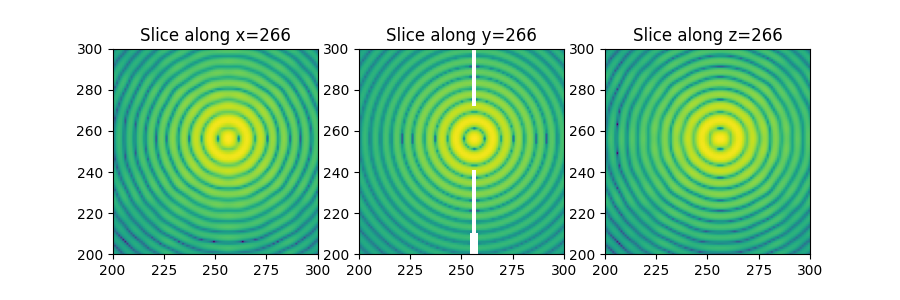

In [17]:
fig, ax = subplots(1, 3, figsize=(9,3))
x = y = z = 266
ax[0].imshow(numpy.arcsinh(res[:,:,x]))
ax[0].set_title(f"Slice along x={x}")

ax[1].imshow(numpy.arcsinh(res[:,y,:]))
ax[1].set_title(f"Slice along y={y}")
ax[2].imshow(numpy.arcsinh(res[z,:,:]))
ax[2].set_title(f"Slice along z={z}")
for i in range(3):
    ax[i].set_xlim(200,300)
    ax[i].set_ylim(200,300)
pass

In [14]:
# numpy.save("volume_512.h5", res)

In [15]:
def new_range(o):
    start = 0.5*(o-1)
    rng = (numpy.arange(o) - start)/o
    return rng

In [16]:
for i in range(1, 10):
    rng = new_range(i)
    print(rng.sum(), rng)

0.0 [0.]
0.0 [-0.25  0.25]
0.0 [-0.33333333  0.          0.33333333]
0.0 [-0.375 -0.125  0.125  0.375]
-5.551115123125783e-17 [-0.4 -0.2  0.   0.2  0.4]
-5.551115123125783e-17 [-0.41666667 -0.25       -0.08333333  0.08333333  0.25        0.41666667]
5.551115123125783e-17 [-0.42857143 -0.28571429 -0.14285714  0.          0.14285714  0.28571429
  0.42857143]
0.0 [-0.4375 -0.3125 -0.1875 -0.0625  0.0625  0.1875  0.3125  0.4375]
2.220446049250313e-16 [-0.44444444 -0.33333333 -0.22222222 -0.11111111  0.          0.11111111
  0.22222222  0.33333333  0.44444444]
